# Fasttext tweet classification

## Data file creation

In [1]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
import random
import re
from nltk.tokenize import TweetTokenizer
from IPython.display import clear_output

In [2]:
DATADIR = "../data/"
TOPIC = "distance"
FILETWEETS = TOPIC+"-tweets.csv"
FILEANNOTATIONS = FILETWEETS+".human-labels.txt"
FILEFASTTEXT = "fasttext-"+TOPIC+".csv"
LABELPREFIX = "__label__"
LARGEINT = 9999999999
LABEL = "label"
TEXT = "text"
USER = "user"
IDSTR = "id_str"
ANNOTATOR = "erikt@xs4all.nl"

In [3]:
tweets = pd.read_csv(DATADIR+FILETWEETS,index_col=IDSTR)
annotations = pd.read_csv(DATADIR+FILEANNOTATIONS,header=None,sep=" ")

In [4]:
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)

In [5]:
fasttextData = {}
for i in range(0,len(annotations)):
    annotator = annotations.iloc[i][0]
    tweetId = annotations.iloc[i][2]
    tweetLabel = annotations.iloc[i][4]
    if annotator == ANNOTATOR and tweetId in list(tweets.index):
        tweetLabel = annotations.iloc[i][4]
        tweetUser = tweets.loc[tweetId][1]
        fasttextData[tweetId] = {LABEL:LABELPREFIX+tweetLabel,\
                                 USER:tweetUser,\
                                 TEXT:" ".join(TweetTokenizer().tokenize(cleanup(tweets.loc[tweetId][TEXT])))}

In [6]:
outFile = open(FILEFASTTEXT,"w")
seenTexts = {}
for tweetId in fasttextData:
    text = cleanup(fasttextData[tweetId][TEXT])
    if not text in seenTexts:
        print(fasttextData[tweetId][LABEL],text,file=outFile)
        seenTexts[text] = True
outFile.close()

In [7]:
nbrOfAnnotationMinutes = len(set([str(x)[:12] for x in annotations[1]]))
nbrOfAnnotatedTweets = len(set([str(x)[:12] for x in annotations[2]]))
print("tweets annotated per minute:",round(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes,1),"; 1000 tweets take:",round(1000/(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes)),"minutes")

tweets annotated per minute: 5.2 ; 1000 tweets take: 194 minutes


## Fasttext run and evaluation

In [8]:
import fasttext
import random
from IPython.display import clear_output

In [9]:
PRETRAINEDDIR = "/home/erikt/projects/newsgac/fasttext-runs/"
WIKIFILENAME = "wiki.nl.vec"

In [10]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

In [11]:
fasttextData = []
inFile = open(FILEFASTTEXT,"r")
for line in inFile: fasttextData.append(line.strip())
inFile.close()
len(fasttextData)

3505

In [12]:
DIM = 100
EPOCH = 100
LR = 0.05
N = 10
TRAIN = "TRAIN"+str(int(random.random()*LARGEINT))
TEST = "TEST"+str(int(random.random()*LARGEINT))

In [13]:
def ranSelect(inList,size):
    outList = []
    selectionList = list(inList)
    while len(outList) < size and len(selectionList) > 0:
        index = int(random.random()*len(selectionList))
        outList.append(selectionList[index])
        del(selectionList[index])
    return(outList)

In [14]:
def runFasttext(fasttextData,dim=DIM,epoch=EPOCH,lr=LR,n=N,squealFlag=True,maxTrain=None):
    predictionCounts = []
    predictionLabels = []
    for fold in range(0,n):
        if squealFlag:
            clear_output(wait=True)
            print("starting fold",fold)
        testStart = round(fold*len(fasttextData)/n)
        testEnd = round((fold+1)*len(fasttextData)/n)
        trainFile = open(TRAIN,"w")
        testFile = open(TEST,"w")
        trainData = []
        testData = []
        for i in range(0,len(fasttextData)):
            data = fasttextData[i]
            if i < testStart or i >= testEnd: 
                print(data,file=trainFile)
                trainData.append(data)
            else: 
                print(data,file=testFile)
                testData.append(data)
        testFile.close()
        trainFile.close()
        if not maxTrain == None and maxTrain < len(trainData):
            trainData = ranSelect(trainData,maxTrain)
            trainFile = open(TRAIN,"w")
            for i in range(0,len(trainData)):
                print(trainData[i],file=trainFile)
            trainFile.close()
        model = fasttext.train_supervised(TRAIN,dim=dim,epoch=epoch,lr=lr)
        predictionCounts.append([*model.test(TEST)])
        predictionLabels.append(model.predict(testData))
        os.unlink(TRAIN)
        os.unlink(TEST)
    if squealFlag:
        clear_output(wait=True)
        print("finished")
    return(predictionCounts,predictionLabels)

In [15]:
def makeConfusionMatrix(fasttextData,predictionLabels):
    goldLabels = pd.Series([fasttextData[i].split()[0] for i in range(0,len(fasttextData))])
    predictedLabels = pd.Series([x[0] for row in predictionLabels for x in row[0]])
    return(pd.crosstab(goldLabels,predictedLabels))

In [16]:
def evaluate(predictionCounts,predictionLabels,fasttextData,printResults=True):
    caseTotal = 0
    pTotal = 0
    rTotal = 0
    for i in range(0,len(predictionCounts)):
        caseTotal += predictionCounts[i][0]
        pTotal += predictionCounts[i][0]*predictionCounts[i][1]
        rTotal += predictionCounts[i][0]*predictionCounts[i][2]
    precision = round(pTotal/caseTotal,3)
    recall = round(rTotal/caseTotal,3)
    cf = makeConfusionMatrix(fasttextData,predictionLabels)
    for label in ['__label__REJECTS','__label__REJECTS','__label__IRRELEVANT']:
        if not label in cf: cf[label] = [0 for i in range(0,3)]
    factor = sum(cf.loc['__label__SUPPORTS'])*sum([cf.iloc[i]['__label__REJECTS'] for i in range(0,len(cf))])/\
             (sum(cf.loc['__label__REJECTS'])*sum([cf.iloc[i]['__label__SUPPORTS'] for i in range(0,len(cf))]))
    if printResults: print("cases: {0}; precision: {1}; recall: {2}; factor: {3:0.3f}".format(caseTotal,precision,recall,factor))
    return((precision,factor))

## Grid search

In [17]:
scores = {}
for dim in [10,20,50,100,200,300]:
    for epoch in [10,20,50,100,200,300]:
        for lr in [0.05,0.1,0.2]:
            predictionCounts,predictionLabels = runFasttext(fasttextData,dim=dim,epoch=epoch,lr=lr,squealFlag=False)
            print(dim,epoch,lr,end=" ")
            key = " ".join([str(dim),str(epoch),str(lr)])
            scores[key] = evaluate(predictionCounts,predictionLabels,fasttextData)

10 10 0.05 cases: 3505; precision: 0.595; recall: 0.595; factor: 0.252
10 10 0.1 cases: 3505; precision: 0.637; recall: 0.637; factor: 0.401
10 10 0.2 cases: 3505; precision: 0.641; recall: 0.641; factor: 0.608
10 20 0.05 cases: 3505; precision: 0.637; recall: 0.637; factor: 0.439
10 20 0.1 cases: 3505; precision: 0.64; recall: 0.64; factor: 0.553
10 20 0.2 cases: 3505; precision: 0.627; recall: 0.627; factor: 0.678
10 50 0.05 cases: 3505; precision: 0.642; recall: 0.642; factor: 0.647
10 50 0.1 cases: 3505; precision: 0.63; recall: 0.63; factor: 0.685
10 50 0.2 cases: 3505; precision: 0.627; recall: 0.627; factor: 0.680
10 100 0.05 cases: 3505; precision: 0.63; recall: 0.63; factor: 0.676
10 100 0.1 cases: 3505; precision: 0.629; recall: 0.629; factor: 0.673
10 100 0.2 cases: 3505; precision: 0.628; recall: 0.628; factor: 0.685
10 200 0.05 cases: 3505; precision: 0.629; recall: 0.629; factor: 0.674
10 200 0.1 cases: 3505; precision: 0.625; recall: 0.625; factor: 0.690
10 200 0.2 cases

In [23]:
dim,epoch,lr = (10,1000,0.2)
predictionCounts,predictionLabels = runFasttext(fasttextData,dim=dim,epoch=epoch,lr=lr,squealFlag=False)
print(dim,epoch,lr,end=" ")
key = " ".join([str(dim),str(epoch),str(lr)])
scores[key] = evaluate(predictionCounts,predictionLabels,fasttextData)

10 1000 0.2 cases: 3505; precision: 0.626; recall: 0.626; factor: 0.701


In [18]:
[(scores[k],k) for k in sorted(scores.keys(),key=lambda k:scores[k][0],reverse=True)][0:10]

[((0.645, 0.6157497728888873), '100 10 0.2'),
 ((0.643, 0.5772708133971292), '20 20 0.1'),
 ((0.642, 0.6468049757178155), '10 50 0.05'),
 ((0.641, 0.6080804207869888), '10 10 0.2'),
 ((0.641, 0.6029606163053427), '300 10 0.2'),
 ((0.64, 0.5534921136948062), '10 20 0.1'),
 ((0.64, 0.5954446006652722), '50 10 0.2'),
 ((0.64, 0.6462917294524838), '200 50 0.05'),
 ((0.639, 0.6252043089980978), '20 10 0.2'),
 ((0.639, 0.6545197619149574), '50 50 0.05')]

In [24]:
[(scores[k],k) for k in sorted(scores.keys(),key=lambda k:scores[k][1],reverse=True)][0:10]

[((0.624, 0.7129848400344775), '10 300 0.2'),
 ((0.626, 0.7096428365023406), '10 500 0.3'),
 ((0.625, 0.7093328134195523), '10 500 0.2'),
 ((0.624, 0.7050547760907169), '50 300 0.2'),
 ((0.629, 0.7014222395754249), '20 50 0.2'),
 ((0.626, 0.7009962689386444), '10 1000 0.2'),
 ((0.624, 0.6999486634418631), '10 300 0.3'),
 ((0.627, 0.6949199560769809), '300 200 0.2'),
 ((0.629, 0.6948276978184408), '50 200 0.2'),
 ((0.627, 0.6931872458062556), '20 100 0.2')]

## Run with best parameters

In [25]:
BESTDIM = 10
BESTEPOCH = 300
BESTLR = 0.2

predictionCounts,predictionLabels = runFasttext(fasttextData,dim=BESTDIM,epoch=BESTEPOCH,lr=BESTLR)

finished


In [26]:
evaluate(predictionCounts,predictionLabels,fasttextData)

cases: 3505; precision: 0.627; recall: 0.627; factor: 0.694


(0.627, 0.6943130390847739)

In [27]:
labelCountsGold = {}
for i in range(0,len(fasttextData)):
    label = fasttextData[i].split()[0]
    if label in labelCountsGold: labelCountsGold[label] += 1
    else: labelCountsGold[label] = 1
labelCountsGold

{'__label__REJECTS': 605,
 '__label__SUPPORTS': 2038,
 '__label__IRRELEVANT': 862}

In [28]:
print("baseline accuracy:",round(max(labelCountsGold.values())/sum(labelCountsGold.values()),3))

baseline accuracy: 0.581


In [29]:
labelCountsPredicted = {}
for i in range(0,len(predictionLabels)):
    for label in predictionLabels[i][0]:
        if label[0] in labelCountsPredicted: labelCountsPredicted[label[0]] += 1
        else: labelCountsPredicted[label[0]] = 1
labelCountsPredicted

{'__label__IRRELEVANT': 743,
 '__label__SUPPORTS': 2290,
 '__label__REJECTS': 472}

In [30]:
print("total absolute deviation",sum([abs(labelCountsPredicted[l]-labelCountsGold[l]) for l in labelCountsGold]))

total absolute deviation 504


In [31]:
print("relative deviation per label:",\
      {l:round(abs(labelCountsPredicted[l]-labelCountsGold[l])/labelCountsGold[l],3) for l in labelCountsGold})

relative deviation per label: {'__label__REJECTS': 0.22, '__label__SUPPORTS': 0.124, '__label__IRRELEVANT': 0.138}


In [32]:
makeConfusionMatrix(fasttextData,predictionLabels)

col_0,__label__IRRELEVANT,__label__REJECTS,__label__SUPPORTS
row_0,,,
__label__IRRELEVANT,323,108,431
__label__REJECTS,142,239,224
__label__SUPPORTS,278,125,1635


For the mondkapje data, fasttext predicts 63% of the labels correctly without external dictionary and 66% with a Wikipedia dictionary (baseline: 46%). It overestimates the presence of negative labels and underestimates the level of positive and neutral labels. The amount of irrelevant labels is about right

In [33]:
multiplicationFactors = {}
for label in labelCountsGold:
    multiplicationFactors[label] = labelCountsGold[label]/labelCountsPredicted[label]
multiplicationFactors

{'__label__REJECTS': 1.2817796610169492,
 '__label__SUPPORTS': 0.8899563318777293,
 '__label__IRRELEVANT': 1.1601615074024225}

For mondkapje tweets, the multiplication factor for the positive label is unrealistically high so we will not use these factors.

In [34]:
predictedNumberOfLabels = 0
for label in labelCountsGold:
    predictedNumberOfLabels += multiplicationFactors[label]*labelCountsPredicted[label]
print(predictedNumberOfLabels,sum(labelCountsGold.values()))

3505.0 3505


## Relation data size - accuracy

In [35]:
N = 5
expResultsAll = {}
for trainingSize in [100,200,500,1000,2000,5000]:
    expResultsTrainingSize = []
    for i in range(0,N):
        selection = ranSelect(fasttextData,trainingSize)
        predictionCounts,predictionLabels = runFasttext(fasttextData,dim=BESTDIM,epoch=BESTEPOCH,lr=BESTLR,squealFlag=False,maxTrain=trainingSize)
        expResultsTrainingSize.append(evaluate(predictionCounts,predictionLabels,fasttextData,printResults=False))
    average = (np.average([x[0] for x in expResultsTrainingSize]),np.average([x[1] for x in expResultsTrainingSize]))
    expResultsAll[len(selection)] = average
    print("{0:4} {1:0.3f} {2:0.3f}".format(len(selection),average[0],average[1]))
    if len(selection) >= len(fasttextData): break

 100 0.546 0.368
 200 0.554 0.461
 500 0.580 0.593
1000 0.597 0.654
2000 0.616 0.698
3505 0.626 0.700


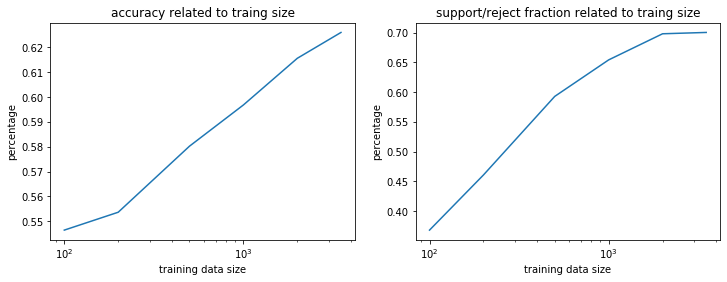

In [38]:
plt.figure(figsize=(12,4))

ax1 = plt.subplot(121)
plt.plot(list(expResultsAll.keys()),[x[0] for x in list(expResultsAll.values())])
plt.xscale("log")
plt.ylabel("percentage")
plt.xlabel("training data size")
plt.title("accuracy related to traing size")

ax1 = plt.subplot(122)
plt.plot(list(expResultsAll.keys()),[x[1] for x in list(expResultsAll.values())])
plt.xscale("log")
plt.ylabel("percentage")
plt.xlabel("training data size")
plt.title("support/reject fraction related to traing size")

plt.show()

## Classifying unlabeled tweets

In [39]:
import fasttext
import matplotlib
import os
import pandas as pd
import re

In [40]:
DATADIRECTORY = "/home/erikt/projects/puregome/data/text/"
LABELPREFIX = "__label__"
NEGATIVE = LABELPREFIX+"NEGATIVE"
POSITIVE = LABELPREFIX+"POSITIVE"
NEUTRAL = LABELPREFIX+"NEUTRAL"
IRRELEVANT = LABELPREFIX+"IRRELEVANT"
SUPPORTS = LABELPREFIX+"SUPPORTS"
REJECTS = LABELPREFIX+"REJECTS"
SUPPORT = ""
TEXT = "text"
USER = "user"
DIM = BESTDIM
EPOCH = BESTEPOCH
LR = BESTLR

In [41]:
def makeGrepCommandFromQuery(query):
    grepCommand = "grep"
    for orPart in query.split("|"):
        grepCommand += ' -e "'+orPart+'"'
    return(grepCommand)

def readData(datePattern,query):
    fileList = sorted(os.listdir(DATADIRECTORY))
    tmpFileName = "classify."+str(int(random.random()*LARGEINT))+".txt"
    testData = []
    for inFileName in fileList:
        if re.search(datePattern,inFileName):
            os.system("gunzip -c "+DATADIRECTORY+inFileName+" 2>/dev/null| head -1 >"+tmpFileName)
            os.system("gunzip -c "+DATADIRECTORY+inFileName+" 2>/dev/null| "+makeGrepCommandFromQuery(query)+" >> "+tmpFileName)
            try: df = pd.read_csv(tmpFileName)
            except: continue
            for i in range(0,len(df)):
                if re.search(query,df.iloc[i][TEXT],flags=re.IGNORECASE):
                    testData.append(df.iloc[i][USER]+" "+df.iloc[i][TEXT])
            os.unlink(tmpFileName)
    return(testData)
    
def classify(datePattern,query):
    testData = readData(datePattern,query)
    model = fasttext.train_supervised(FILEFASTTEXT,dim=DIM,epoch=EPOCH,lr=LR)
    predictedLabels = model.predict(testData)
    predictedGroups = pd.DataFrame(predictedLabels[0]).groupby(0).groups
    labelCountsPredicted = {label:len(predictedGroups[label]) for label in predictedGroups}
    nbrOfLabels = sum([labelCountsPredicted[label] for label in labelCountsPredicted if label != IRRELEVANT])
    labelPercentages = { label:round(100*labelCountsPredicted[label]/nbrOfLabels,1) for label in labelCountsPredicted}
    return(labelPercentages)

In [42]:
QUERY = "1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"
MAXDAYSPERMONTH = 31

results = {}
for month in "202002 202003 202004 202005 202006 202007".split():
    for day in range(1,MAXDAYSPERMONTH+1):
        date = month+str(day).zfill(2)
        try:
            labels = classify(date,QUERY)
            if not REJECTS in labels: labels[REJECTS] = 0
            if not SUPPORTS in labels: labels[SUPPORTS] = 0
            if not IRRELEVANT in labels: labels[IRRELEVANT] = 0
            if labels[REJECTS]+labels[SUPPORTS]+labels[IRRELEVANT] > 0:
                results[date] = labels
            print(date,labels[REJECTS],labels[SUPPORTS],labels[IRRELEVANT])
        except:
            print(date,"error")

20200201 4.0 96.0 206.0
20200202 12.5 87.5 262.5
20200203 4.7 95.3 131.2
20200204 3.3 96.7 110.9
20200205 6.0 94.0 154.0
20200206 35.9 64.1 223.1
20200207 10.2 89.8 228.6
20200208 6.1 93.9 218.4
20200209 12.3 87.7 164.2
20200210 26.9 73.1 101.3
20200211 18.8 81.2 577.1
20200212 3.0 97.0 163.6
20200213 11.2 88.8 165.0
20200214 9.2 90.8 172.3
20200215 9.1 90.9 268.2
20200216 4.9 95.1 149.2
20200217 5.2 94.8 187.9
20200218 10.4 89.6 144.8
20200219 10.0 90.0 352.5
20200220 8.7 91.3 821.7
20200221 10.0 90.0 427.5
20200222 16.3 83.7 258.1
20200223 2.2 97.8 129.0
20200224 2.9 97.1 267.1
20200225 31.3 68.7 191.0
20200226 12.9 87.1 265.7
20200227 3.0 97.0 114.8
20200228 11.6 88.4 100.0
20200229 19.1 80.9 170.6
20200230 error
20200231 error
20200301 13.0 87.0 123.0
20200302 12.1 87.9 99.0
20200303 3.3 96.7 85.6
20200304 5.1 94.9 235.6
20200305 10.0 90.0 226.2
20200306 5.8 94.2 148.9
20200307 4.8 95.2 79.2
20200308 4.4 95.6 50.0
20200309 5.6 94.4 62.0
20200310 5.1 94.9 71.5
20200311 5.2 94.8 53.7

## Visualization over time

In [43]:
def movingAverage(numberList,size):
    newList = []
    for i in range(0,len(numberList)):
        numberUsed = 1
        newList.append(numberList[i])
        for j in range(1,size):
            if i-j >= 0:
                newList[i] += numberList[i-j]
                numberUsed += 1
        newList[i] /= numberUsed
    return(newList)

/home/erikt/anaconda3/envs/python37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


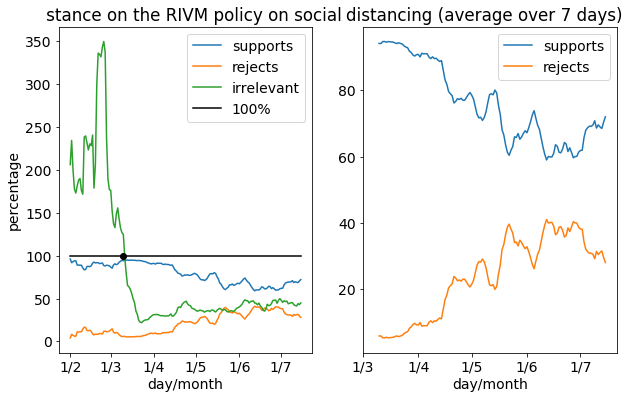

In [44]:
DATEFORMAT = "%Y%m%d"
DAYSCOMBINED = 7
STARTDATE = "20200310"
ENDDATE = "20201231"

results = {k:results[k] for k in sorted(results.keys())}
font = {"size":14}
matplotlib.rc("font",**font)
plt.subplots(figsize=(10,6))
x = [datetime.datetime.strptime(k,DATEFORMAT) for k in results.keys()]
ySupports = movingAverage([results[k][SUPPORTS] for k in results.keys()],DAYSCOMBINED)
yRejects = movingAverage([results[k][REJECTS] for k in results.keys()],DAYSCOMBINED)
yIrrelevant = movingAverage([results[k][IRRELEVANT] for k in results.keys()],DAYSCOMBINED)

ax1 = plt.subplot(121)
plt.plot_date(x,ySupports,fmt="-",label="supports")
plt.plot_date(x,yRejects,fmt="-",label="rejects")
plt.plot_date(x,yIrrelevant,fmt="-",label="irrelevant")
plt.plot_date(x,[100 for i in x],fmt="-",label="100%",color="black")
for date in [STARTDATE]:
    plt.plot_date([datetime.datetime.strptime(date,DATEFORMAT)],[100],color="black")
plt.legend()
plt.ylabel("percentage")
plt.xlabel("day/month")
plt.title("   stance on the RIVM policy on "+"social")

dates = [d for d in results.keys()]
xPart = [x[i] for i in range(0,len(dates)) if dates[i] >= STARTDATE and dates[i] <= ENDDATE]
ySupportsPart = [ySupports[i] for i in range(0,len(dates)) if dates[i] >= STARTDATE and dates[i] <= ENDDATE] 
yRejectsPart = [yRejects[i] for i in range(0,len(dates)) if dates[i] >= STARTDATE and dates[i] <= ENDDATE]
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))

ax2 = plt.subplot(122)
plt.plot_date(xPart,ySupportsPart,fmt="-",label="supports")
plt.plot_date(xPart,yRejectsPart,fmt="-",label="rejects")
plt.legend()
plt.xlabel("day/month")
plt.title("distancing (average over "+str(DAYSCOMBINED)+" days)  ")
plt.xticks([datetime.datetime.strptime(d,DATEFORMAT) for d in "20200301 20200401 20200501 20200601 20200701".split()])
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))

plt.show()

In [45]:
for i in range(0,len(yIrrelevant)):
    if i < len(yIrrelevant)-1 and \
       (yIrrelevant[i] < 100 and yIrrelevant[i+1] >= 100 or yIrrelevant[i] >= 100 and yIrrelevant[i+1] < 100):
        print(list(results.keys())[i])

20200310
